# Paper Soccer Demo Notebook

This notebook shows how to interact with environment that simulates playing in paper soccer.

There are three concepts to get familiar with:

- **Board** - board class with methods to interact with environment; equipped with method to draw the board
- **SingleBlock** - internal structure that represents each building-block of soccer game (data is bit-encoded in single value sou if you want to interact with the raw data you should transform it to separate bits)
- **Actor** - Actually the actors are created in this notebook and show possible ways of interacting with the environment

In [1]:
# Notebook dependencies
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm

# paper soccer library
from papersoccer_env import Board

# Board object

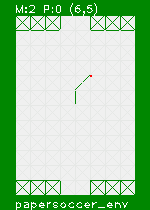

In [2]:
board = Board()
board.move("T")
board.move("TR")
Image.fromarray(board.draw())

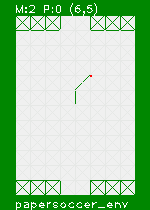

In [3]:
# copy board, changing source deos not change copy
board2 = board.copy()
board.move("T")
Image.fromarray(board2.draw())

moves made:1, valid_move=True, next_player=1, winner=None
moves made:2, valid_move=True, next_player=0, winner=None
moves made:3, valid_move=True, next_player=1, winner=None
moves made:4, valid_move=True, next_player=0, winner=None
moves made:5, valid_move=True, next_player=1, winner=None
moves made:5, valid_move=True, next_player=None, winner=0


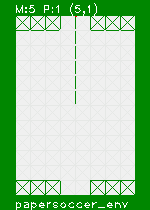

In [4]:
# move - returned values
board = Board()

move_code = "T"

valid_move, next_player, winner = board.move(move_code)
print(f"moves made:{board.moves}, valid_move={valid_move}, next_player={next_player}, winner={winner}")
valid_move, next_player, winner = board.move(move_code)
print(f"moves made:{board.moves}, valid_move={valid_move}, next_player={next_player}, winner={winner}")
valid_move, next_player, winner = board.move(move_code)
print(f"moves made:{board.moves}, valid_move={valid_move}, next_player={next_player}, winner={winner}")
valid_move, next_player, winner = board.move(move_code)
print(f"moves made:{board.moves}, valid_move={valid_move}, next_player={next_player}, winner={winner}")
valid_move, next_player, winner = board.move(move_code)
print(f"moves made:{board.moves}, valid_move={valid_move}, next_player={next_player}, winner={winner}")
valid_move, next_player, winner = board.move("T")
print(f"moves made:{board.moves}, valid_move={valid_move}, next_player={next_player}, winner={winner}")

Image.fromarray(board.draw())

# Drawing game via seqience of moves

In [5]:
_,img,img_game = Board.play_sequence(["T","TL","TR","R","B","L","BR","BL"])

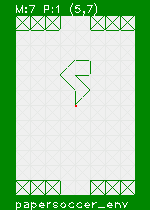

In [6]:
Image.fromarray(img)

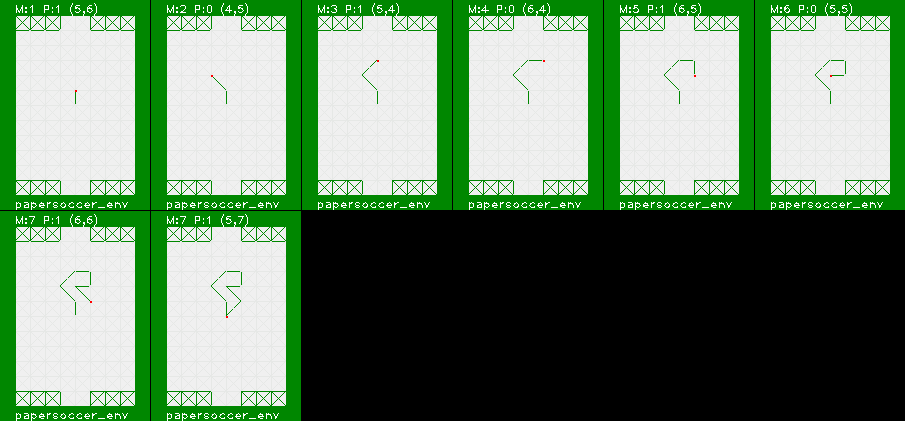

In [7]:
Image.fromarray(img_game)

# Playing with the environment

Section below shows how to approach a implementation of an actor (those are really silly ones).
Basically there in only one methods to be implemented:
* move

Method of moving takes environment as a parameter. Environment variables are accessible so you can get **environment state**. Environment has methods to support takieng **actions**:
- possible_moves(...) - returns a list of possible moves
- move(...) - performs a move, returns information if move was valid, who is nest to play and if anybody has already won

## Random actor

In [8]:
class Actor():
    def __init__(self, name):
        self.name = name
        
    def get_name(self):
        return self.name
    
    def move(self, board):
        raise Exception("move(...): Not implemented")
        
class RandomActor(Actor):
    def __init__(self, name):
        super(RandomActor, self).__init__("Random_"+name)
    
    def move(self, board):
        moves_dict = board.possible_moves()
        moves = []
        for key in moves_dict:
            if moves_dict[key]:
                moves.append(key)

        index = np.random.randint(0,len(moves))
        return moves[index]

## Tournament

In [9]:
def play_game(playerA, playerB, max_moves):
    board = Board()
    next_player = 0
    sequence = []
    for i in range(max_moves):
        if next_player == 0:
            move = playerA.move(board)
        else:
            move = playerB.move(board)
            
        valid_move, next_player, winner = board.move(move)
        sequence.append(move)
        if winner is not None:
            return i, winner, sequence       
        
    return max_moves, 0.5, sequence # draw if moves exhausted

def play_tournament(players, rounds=100, max_moves=1000):
    
    points = {p.get_name():0 for p in players}
    
    all_games = len(players)*(len(players)-1)*rounds
    progress = tqdm(total=all_games)
    
    history = []
    
    for round in range(rounds):
        for pa, playerA in enumerate(players):
            for pb, playerB in enumerate(players):
                if pa<pb:
                    moves, pointsA, sequence = play_game(playerA, playerB, max_moves)
                    history.append( (playerA.get_name(), playerB.get_name(), pointsA, sequence) )
                    progress.update()
                    
                    moves, pointsB,_ = play_game(playerB, playerA, max_moves)
                    history.append( (playerB.get_name(), playerA.get_name(), pointsB, sequence) )
                    progress.update()
                    
                    points[playerA.get_name()] += pointsA + (1-pointsB)
                    points[playerB.get_name()] += pointsB + (1-pointsA)               
    return points, history

## Random play

In [10]:
points, history  = play_tournament([RandomActor("1"),RandomActor("2"),RandomActor("3")])

# Returns points after tournament (1-win; 0-loss; 0.5-draw)
points

{'Random_1': 192, 'Random_2': 196, 'Random_3': 212}

### Stats of the game lengths

Average game length 36.86333333333334
Median game length 31.0
Min game length 5
Max game length 134


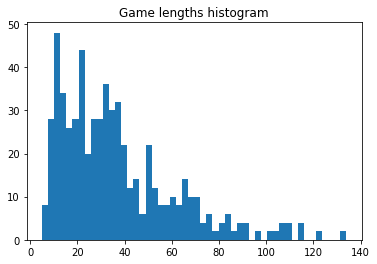

In [11]:
lengths = [len(h[3]) for h in history]
print("Average game length",np.mean(lengths))
print("Median game length",np.median(lengths))
print("Min game length",np.min([lengths]))
print("Max game length",np.max([lengths]))

plt.hist(lengths, bins=50)
plt.title("Game lengths histogram")
del history

## Greedy actors

In [12]:
class TryOnlyBestActor(Actor):
    def __init__(self, name):
        super(TryOnlyBestActor, self).__init__("TryBest_"+name)
    
    def move(self, board):
        moves_dict = board.possible_moves()
        target = board.winning_positions[board.player_to_move][0]
        
        y,x = board.ball_pos
        ty,tx = target
        
        # Calculate preference
        vert_preference = ""
        horiz_preference = ""
        
        if tx<x:
            horiz_preference="L"
        elif tx>x:
            horiz_preference="R"
            
        if ty<y:
            vert_preference="T"
        elif ty>y:
            vert_preference="B"
            
        shortest_move = vert_preference+horiz_preference

        # Possible moves
        moves = []
        for key in moves_dict:
            if moves_dict[key]:
                moves.append(key)
                
        # Try best     
        if shortest_move in moves:
            return shortest_move

        index = np.random.randint(0,len(moves))
        return moves[index]

In [13]:
class GreedyActor(Actor):
    def __init__(self, name):
        super(GreedyActor, self).__init__("Greedy_"+name)
    
    def move(self, board):
        moves_dict = board.possible_moves()
        target = board.winning_positions[board.player_to_move][0]
        
        y,x = board.ball_pos
        ty,tx = target
        
        # Calculate preference
        vert_preference = ""
        horiz_preference = ""
        
        if tx<x:
            horiz_preference="L"
        elif tx>x:
            horiz_preference="R"
            
        if ty<y:
            vert_preference="T"
        elif ty>y:
            vert_preference="B"
            
        shortest_move = vert_preference+horiz_preference

        # Possible moves
        moves = []
        for key in moves_dict:
            if moves_dict[key]:
                moves.append(key)
         
         # Try best    
        if shortest_move in moves:
            return shortest_move
        
         # Try horiz direction
        for m in moves:
            if horiz_preference in m:
                return m
            
         # Try vert direction
        for m in moves:
            if vert_preference in m:
                return m

        index = np.random.randint(0,len(moves))
        return moves[index]

# Combined tournament

In [14]:
# One of each
points, _  = play_tournament([RandomActor("1"),GreedyActor("2"),TryOnlyBestActor("3")], rounds=1000)

# Returns points after tournament (1-win; 0-loss; 0.5-draw)
points

{'Random_1': 1082, 'Greedy_2': 3231, 'TryBest_3': 1687}

In [15]:
# Two of each
points, _  = play_tournament([RandomActor("1"),GreedyActor("2"),TryOnlyBestActor("3"),
                              RandomActor("4"),GreedyActor("5"),TryOnlyBestActor("6")], rounds=1000)

# Returns points after tournament (1-win; 0-loss; 0.5-draw)
points

{'Random_1': 3057,
 'Greedy_2': 7540,
 'TryBest_3': 4373,
 'Random_4': 3022,
 'Greedy_5': 7569,
 'TryBest_6': 4439}